In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
from src.wards_data import WardDataset

In [2]:
load_dotenv()

STRATZ_TOKEN = os.getenv('STRATZ_TOKEN')
if not STRATZ_TOKEN:
    raise FileNotFoundError("Not found STRATZ_TOKEN on .env")

ward_dataset = WardDataset(STRATZ_TOKEN)

In [3]:
df_data = ward_dataset.get_by_time_merged_dataset()
df_data

time               id       match  positionX  positionY  wardType  \
0         -2   7811671022_450  7811671022         38         36  OBSERVER   
1         -1   7811671022_450  7811671022         38         36  OBSERVER   
2          0   7811671022_450  7811671022         38         36  OBSERVER   
3          1   7811671022_450  7811671022         38         36  OBSERVER   
4          2   7811671022_450  7811671022         38         36  OBSERVER   
...      ...              ...         ...        ...        ...       ...   
176909    51   7812389654_411  7812389654         43         49  OBSERVER   
176910    52   7812389654_411  7812389654         43         49  OBSERVER   
176911    51  7812389654_2292  7812389654         43         49    SENTRY   
176912    52  7812389654_2292  7812389654         43         49    SENTRY   
176913    52  7812389654_2956  7812389654         23         21    SENTRY   

        isRadiant playerDestroyed  didRadiantWin        radiantTeam  \
0            True            None           True     Tundra Esports   
1            True            None           True     Tundra Esports   
2            True            None           True     Tundra Esports   
3            True            None           True     Tundra Esports   
4            True            None           True     Tundra Esports   
...           ...             ...            ...                ...   
176909       True            None          False  Yangon Galacticos   
176910       True            None          False  Yangon Galacticos   
176911       True            None          False  Yangon Galacticos   
176912       True            None          False  Yangon Galacticos   
176913       True            None          False  Yangon Galacticos   

            direTeam  league  region  \
0          PSG.Quest   16842  EUROPE   
1          PSG.Quest   16842  EUROPE   
2          PSG.Quest   16842  EUROPE   
3          PSG.Quest   16842  EUROPE   
4          PSG.Quest   16842  EUROPE   
...              ...     ...     ...   
176909  Neon Esports   16775     SEA   
176910  Neon Esports   16775     SEA   
176911  Neon Esports   16775     SEA   
176912  Neon Esports   16775     SEA   
176913  Neon Esports   16775     SEA   

                                               leagueName  didWardWin  
0       Road To The International 2024  - Regional Qua...        True  
1       Road To The International 2024  - Regional Qua...        True  
2       Road To The International 2024  - Regional Qua...        True  
3       Road To The International 2024  - Regional Qua...        True  
4       Road To The International 2024  - Regional Qua...        True  
...                                                   ...         ...  
176909  Elite League Season 2 SEA Closed Qualifiers – ...       False  
176910  Elite League Season 2 SEA Closed Qualifiers – ...       False  
176911  Elite League Season 2 SEA Closed Qualifiers – ...       False  
176912  Elite League Season 2 SEA Closed Qualifiers – ...       False  
176913  Elite League Season 2 SEA Closed Qualifiers – ...       False  

[176914 rows x 15 columns]

In [4]:
len(df_data['match'].unique())

426

In [5]:
df_data['leagueName'].unique()

array(['Road To The International 2024  - Regional Qualifiers Western Europe',
       'Road To The International 2024  - Regional Qualifiers Southeast Asia',
       'Road To The International 2024  - Regional Qualifiers South America',
       'Road To The International 2024 - Regional Qualifiers Eastern Europe',
       'Road To The International 2024 - Regional Qualifiers China',
       'Road To The International 2024  - Regional Qualifiers North America',
       'Elite League Season 2 EEU Closed Qualifiers – presented by ESB',
       'Elite League Season 2 WEU Closed Qualifiers – presented by ESB',
       'Elite League Season 2 SA Closed Qualifiers – presented by ESB',
       'Elite League Season 2 NA Closed Qualifiers – presented by ESB',
       'Elite League Season 2 CN Closed Qualifiers – presented by ESB',
       'Elite League Season 2 SEA Closed Qualifiers – presented by ESB'],
      dtype=object)

In [6]:
BG_MAP_SIZE = np.array((5000, 5000))

Text(0.5, 1.0, 'Most extreme coordinates wards')

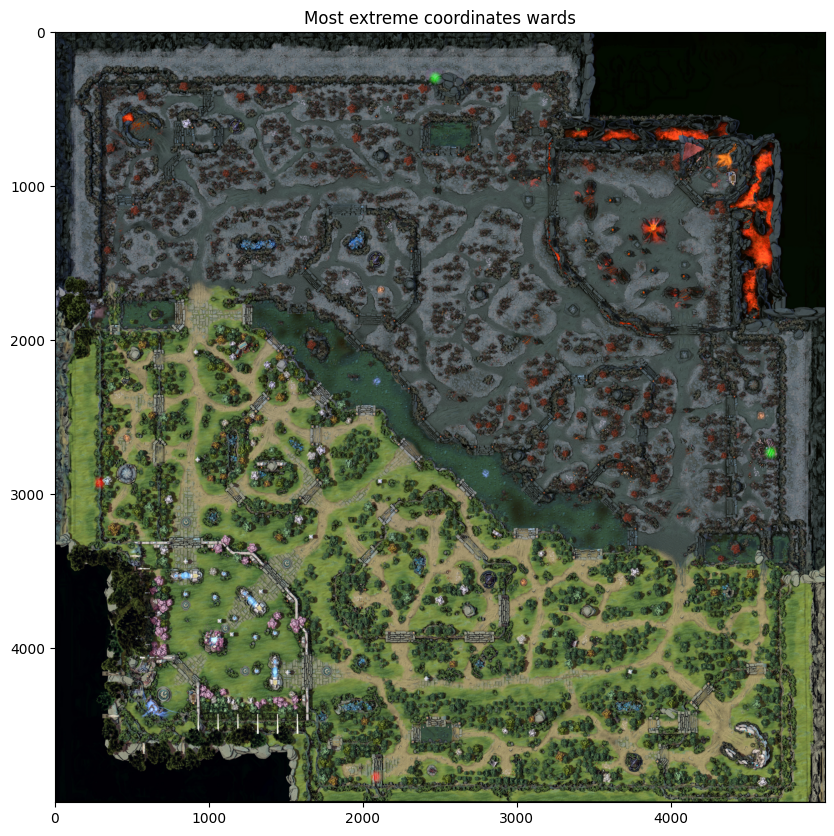

In [7]:

import matplotlib.patches as mpatches
map_size = (df_data['positionY'].max()+5, df_data['positionX'].max()+5)
def wards_hotmap(df: pd.DataFrame):
    
    # load bg_map
    bg_map = np.array(Image.open('assets\Game_map_7.33.webp').resize(BG_MAP_SIZE))

    positionX = df['positionX']
    positionY = df['positionY']
    isRadiant = df['isRadiant']
    didWardWin = df['didWardWin']
    
    
    map = np.zeros((map_size[0], map_size[1], 3))

    for px, py, is_radiant, did_ward_win in zip(positionX, positionY, isRadiant, didWardWin):
        color_channels = (False,True,False) if is_radiant else (True,False,False)
        # print(map[py, px, color_channels])
        map[py, px, color_channels] += 1 # if did_ward_win else -1
    map = np.clip(map * 1., a_min=0, a_max=float("+inf"))
    #map[:,:,0] = (map[:,:,0] * 255.) // map[:,:,0].max()
    #map[:,:,1] = (map[:,:,1] * 255.) // map[:,:,1].max()
    #map[:,:,2] = (map[:,:,2] * 255.) // map[:,:,2].max()
    map = (map * 255) // map.max()
    map = np.flip(map, axis=0)
    map_to_pil = map.astype(np.uint8)
    map = np.array(Image.fromarray(map_to_pil).resize(BG_MAP_SIZE, resample=Image.Resampling.LANCZOS))
    map = np.clip(map * 1., a_min=0, a_max=230)
    
    map_alpha = map / 255

    merged_map = map * map_alpha + bg_map * (1 - map_alpha)
    merged_map = np.array(merged_map, dtype=np.uint8)

    return merged_map

mask = df_data['wardType'] == "OBSERVER"

df_observer = df_data[mask].reset_index()

sample = pd.concat([
    df_observer.iloc[df_observer['positionX'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionX'].idxmin()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmin()].to_frame().T,
])

plt.figure(figsize=(10,10))
plt.imshow(wards_hotmap(sample))
plt.title("Most extreme coordinates wards")

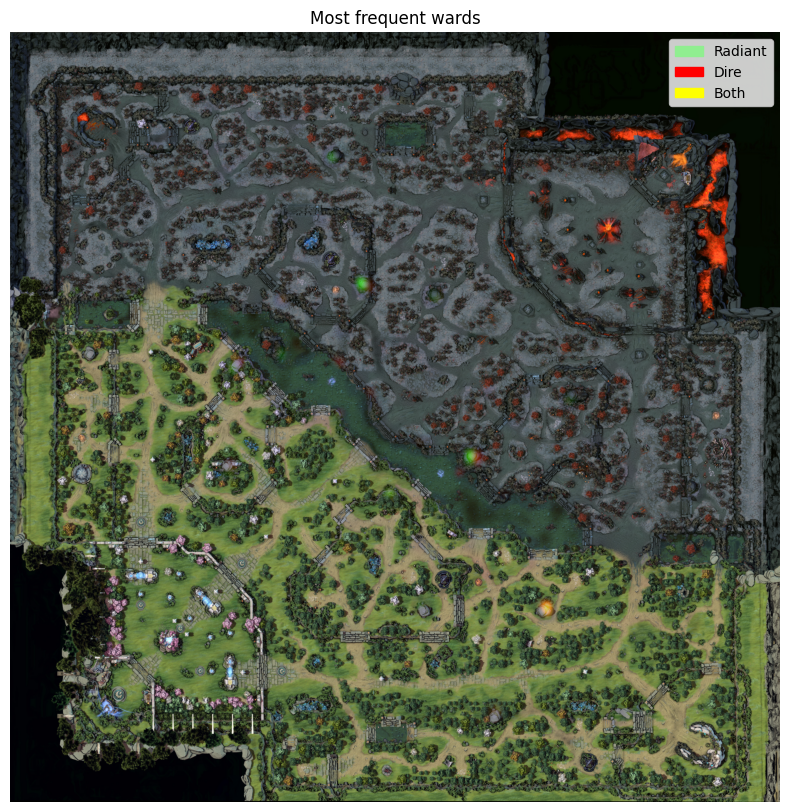

In [8]:
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Most frequent wards")

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='#90ee90', label='Radiant'),
    mpatches.Patch(color='red', label='Dire'),
    mpatches.Patch(color='yellow', label='Both')
]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right')

plt.imshow(wards_hotmap(df_observer))
plt.show()

<Axes: ylabel='Frequency'>

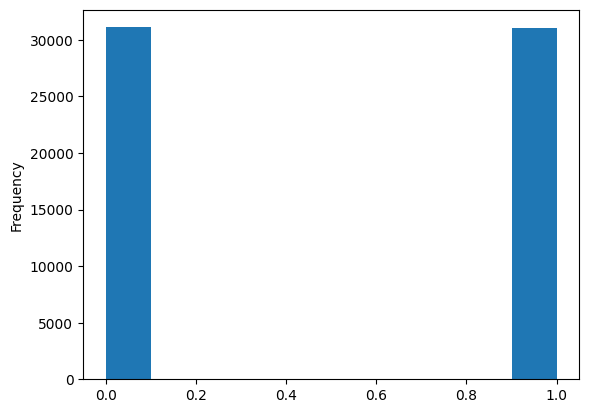

In [9]:
df_observer['isRadiant'].astype(int).plot(kind='hist')

In [10]:
# df_observer['score'] = df_observer['didWardWin'].map(lambda x: 1 if x == True else 0)
grouped_score = df_observer.groupby(['positionX', 'positionY', 'isRadiant'])['didWardWin']
df_scores = grouped_score.count().reset_index(name="wardCount")
df_scores['wins'] = grouped_score.sum().reset_index()['didWardWin']
# df_scores = grouped_score.sum().to_frame()
# df_scores = df_scores.reset_index()
# df_scores[['wards_count']].plot(kind='hist', bins=12, alpha=0.5)
df_scores['winRate'] = df_scores['wins'] /  df_scores['wardCount']
df_scores

positionX  positionY  isRadiant  wardCount  wins  winRate
0             4         31      False          1     1      1.0
1             5         36       True          6     0      0.0
2             5         53       True          6     0      0.0
3             6         29       True          7     0      0.0
4             6         30      False          6     6      1.0
...         ...        ...        ...        ...   ...      ...
2529         72         34       True          2     2      1.0
2530         72         35       True          2     2      1.0
2531         72         36       True          6     0      0.0
2532         72         37      False          4     0      0.0
2533         72         37       True          6     6      1.0

[2534 rows x 6 columns]

<Axes: title={'center': 'Winrate distribution before mask'}, ylabel='Frequency'>

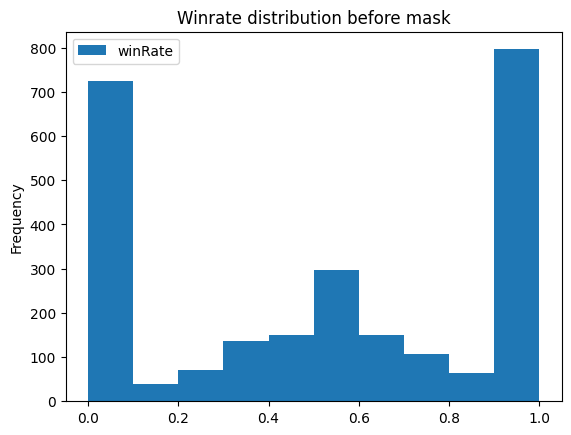

In [11]:
df_scores[['winRate']].plot(kind='hist', title="Winrate distribution before mask")

<Axes: title={'center': 'Winrate distribution after mask'}, ylabel='Frequency'>

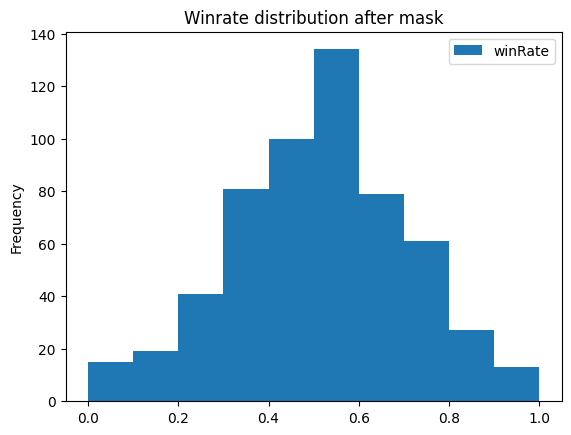

In [12]:
mask = df_scores['wardCount'] > df_scores['wardCount'].mean()
df_scores_masked = df_scores[mask]
df_scores_masked[['winRate']].plot(kind='hist', title="Winrate distribution after mask")

<Axes: title={'center': 'wardCount / max(wardCount)'}, ylabel='Frequency'>

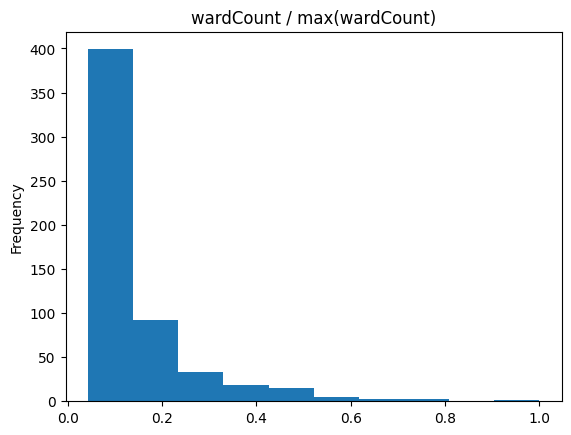

In [13]:
(df_scores_masked['wardCount'] / df_scores_masked['wardCount'].max()).plot(kind='hist', title="wardCount / max(wardCount)")

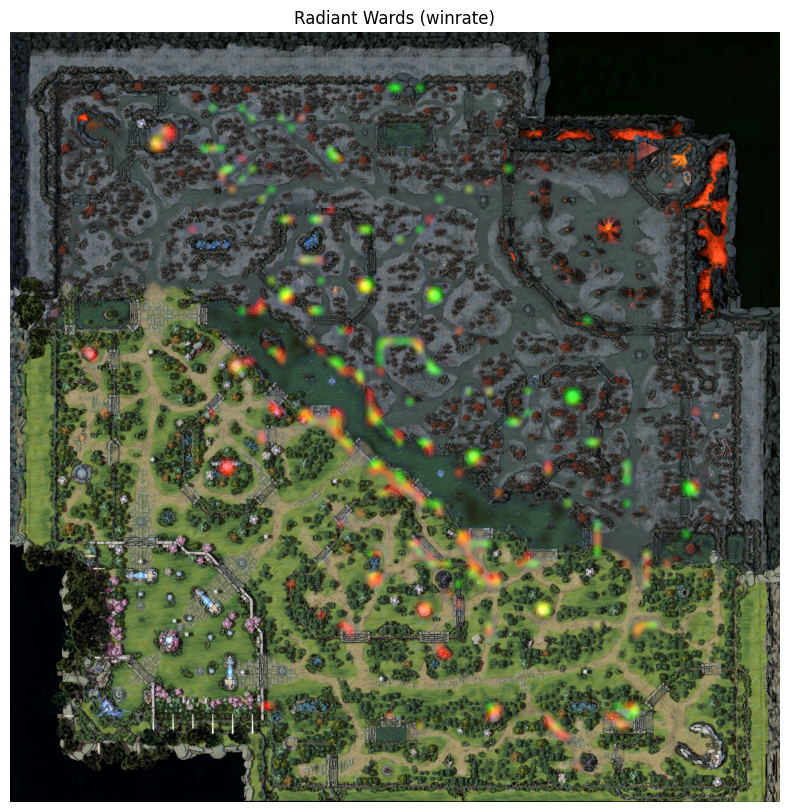

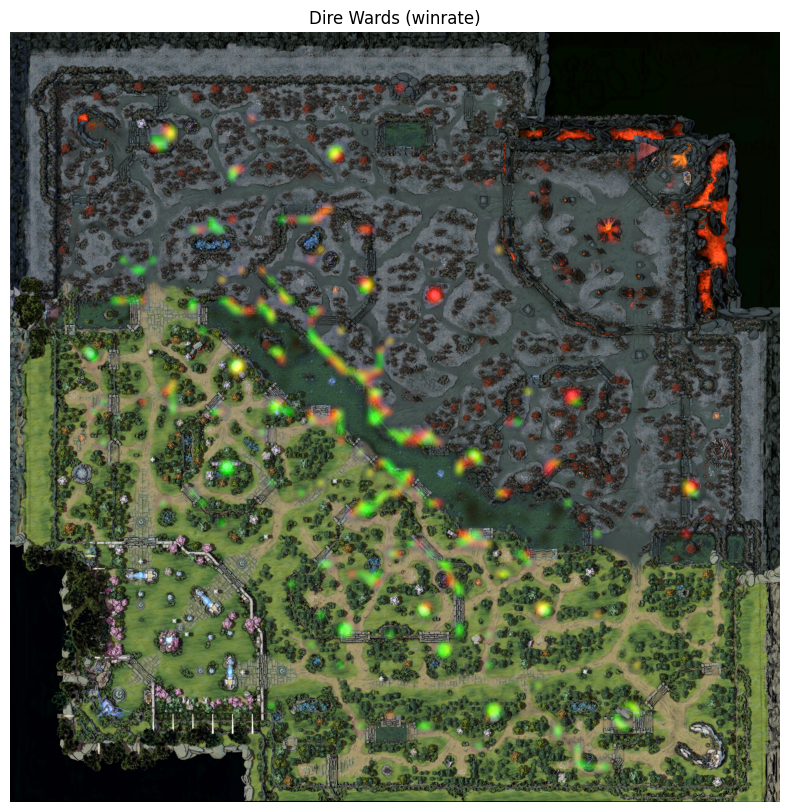

In [14]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def rescale_pixel(map, factor=1, limit=255):
    max_value = np.max(map, axis=2)
    mask = max_value > 0
    max_factor = np.zeros_like(max_value)
    max_factor[mask] = limit / max_value[mask]
    curr_factor = max_factor
    curr_factor_mask = factor < max_factor
    curr_factor[curr_factor_mask] = factor
    return map * curr_factor[:, :, np.newaxis] 

def wards_hotmap_winrate(df: pd.DataFrame):
    
    # load bg_map
    bg_map = np.array(Image.open('assets\Game_map_7.33.webp').resize(BG_MAP_SIZE))

    positionX = df['positionX']
    positionY = df['positionY']
    winRate = df['winRate']
    wardCount = df['wardCount']
    
    # get blank arr map
    
    map = np.zeros((map_size[0], map_size[1], 3))

    for px, py, win_rate, ward_count in zip(positionX, positionY, winRate, wardCount):
        red = (1 - win_rate) * ward_count
        green = win_rate * ward_count
        blue = 0
        map[py, px] = (red, green, blue)
    map = np.clip(map * 1., a_min=0, a_max=float("+inf"))
    map = (map * 255) // map.max()
    map = np.flip(map, axis=0)
    map = rescale_pixel(map, 50, 195)
    
    map_to_pil = map.astype(np.uint8)
    map = np.array(Image.fromarray(map_to_pil).resize(BG_MAP_SIZE, resample=Image.Resampling.LANCZOS))
    # map = np.clip(map * 1., a_min=0, a_max=195)
    map_alpha = map / 255

    merged_map = map * map_alpha + bg_map * (1 - map_alpha)
    merged_map = np.array(merged_map, dtype=np.uint8)

    return merged_map

# radiant
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Radiant Wards (winrate)")
plt.imshow(wards_hotmap_winrate(df_scores_masked[df_scores_masked['isRadiant'] == True]))

# dire
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Dire Wards (winrate)")
plt.imshow(wards_hotmap_winrate(df_scores_masked[df_scores_masked['isRadiant'] == False]))

In [15]:
df_scores.sort_values("wardCount", ascending=False)

positionX  positionY  isRadiant  wardCount  wins   winRate
2061         54         19      False        583   301  0.516295
1194         35         51       True        463   201  0.434125
2059         54         18      False        456   298  0.653509
1745         46         34       True        424   244  0.575472
2062         54         19       True        415   216  0.520482
...         ...        ...        ...        ...   ...       ...
789          28         13      False          1     1  1.000000
767          27         53       True          1     1  1.000000
2350         62         46       True          1     1  1.000000
2352         62         49       True          1     1  1.000000
0             4         31      False          1     1  1.000000

[2534 rows x 6 columns]

## tensor

In [16]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
torch.tensor

<function torch._VariableFunctionsClass.tensor>